# How to use nuc_syndat to sample a synthetic, true cross section





In [30]:
import syndat
import os
import numpy as np
from matplotlib.pyplot import *
# import nuctools as nuc
import pandas as pd
import scipy.linalg as spla

In [31]:
%matplotlib widget


### Define energy grid 

Energy grid data should be linear in time of flight, but is often then grouped together by the experimentalist before it is passed to the evaluator. This grouping is artisanal, and therefore difficult to come up with a generalized way to emulate it. For now, we will pull the tof from an experiment done at RPI.


In [32]:

estruct_lst = syndat.sammy_interface.readlst('../synthetic_data/Ta181/estruct')
estruct_lst.sort_values('E', inplace=True)
estruct_lst.reset_index(drop=True, inplace=True)
energy = estruct_lst.E

### Get average parameters
You can run SAMMY to interpret ENDF files. This creates a SAMQUA.PAR file that contains the RRR parameters as evaluated in ENDF. The function read_SAMNDF_PAR in sammy_interface reads this file and returns a dataframe with average parameters and all parameters. 

Note: The reduced width average parameters are not corrected for small (PT) widths that are likely missed. This should be updated.

In [33]:

average_parameters, parameters = syndat.sammy_interface.read_SAMNDF_PAR('../synthetic_data/Ta181/SAMQUA.PAR')
print(average_parameters);# print(parameters)

           dE         Gg         Gn
2.0  7.929756  55.619048  18.222876
1.0  9.764375  56.515152  21.188554


### Spin group determination

The syndat package has a set of functions that calculate possible spin groups given some set of nuclear parameters for the incident/target particle. Each spin group has a sequence of resonances (or excited states), the parameters for which have been observed to fall on well established statistical distributions. This is important in the context of generating a synthetic cross section, each spin group will have a statistically sampled resonance sequence that will contribute to the "observed" cross section.

Spin groups are characterized by a particular total orbital angular momentum and parity ($J^{\pi}$) which is a function of the channel spin ($\vec{s}$) and the orbital angular momentum of the pair ($\vec{l}$)

<br/> $\vec{s} = \vec{i} + \vec{I}$ <br/> $\vec{J^{\pi}} = \vec{l}+\vec{s} $ <br/>

Where $\vec{i}$ and $\vec{I}$ are the angular momenta of the incident and target particle respectively. The orbital angular moment of the pair ($\vec{l}$) corresponds to a Legendre expansion of the angular momenta eigenfunctions in the cross section formalism and are often described as s-wave, p-wave, d-wave, f-wave... and so-on channels (l=0,1,2,3). Consequently, a large number of l-values can be considered, however, the cross section observed converges quickly as higher order waves have an decreasing probability of penetrating the centrifugal barrier (the partial width, is driven down by the penetrability factor applied to the reduced width amplitudes). Each of the functions above are quantized vector sums calculated as:

<br/> $|\vec{l}-\vec{l'}| \leq L \leq \vec{l}+\vec{l'} $<br/> 

and each of the quantum numbers have an associated parity that is conserved as a multiplication:

<br/> (-)(+)=(-)<br/> (+)(+)=(+)<br/> (-)(-)=(+)

The syndat code has the capability to do this spin group mapping to determine the allows channels. The following code cell shows an example of how this is done using the map_quantum_numbers function within the spin_groups module. The function returns ordered lists for the possible total orbital angular momenta for positive and negative parity and give the option to print out a summary. 

In [34]:
ac = 8.1271e-15 # scattering radius in m 
M = 180.948030  # amu of target nucleus
m = 1           # amu of incident neutron
I = 3.5         # intrinsic spin, positive parity
i = 0.5         # intrinsic spin, positive parity
l_max = 0       # highest order l-wave to consider

pair = syndat.particle_pair(ac, M, m, I, i, l_max)

pair.map_quantum_numbers(True)


The following arrays describe all possible spin groups for a each parity.
    The data is given as a tuple where the first value is the integer 
    or half integer total quantum spin J and the second value is the 
    number of entrance channels for that spin group. 
    * See the dictionary "possible_Jpi" for a nested packing structure.

Spin group data for negative parity
(J-, #Chs, l-waves)

Spin group data for positive parity
(J+, #Chs, l-waves)
(3.0, 1, [0.0])
(4.0, 1, [0.0])


### Resonance sequence sampling

Each spin group has a sequence of resonances who's parameters fall on well established statistical distributions independent of the other spin groups. The syndat code also has this capability with the function sample_all_Jpi in the spin_groups module. In fact, the previous step of quantum spin group mapping is unnecessary as this function will do the mapping again (this is why the print_out function is now set to false).

Statistical distributions of resonance parameters are relative to the average value of the parameter... elaborate here.

In [35]:

Davg = [list(), list([average_parameters.dE[1],average_parameters.dE[2]])]
Ggavg = [list(), list([average_parameters.Gg[1],average_parameters.Gg[2]])]
Gnavg = [list(), list([average_parameters.Gn[1],average_parameters.Gn[2]])]


In [36]:

RRR_Erange = [1, 600]
save_csv = True

pair.sample_all_Jpi(RRR_Erange, 
                        Davg, Ggavg, Gnavg,
                        save_csv = True, 
                        sammy_run_folder = '../synthetic_data/Ta181/postdoc_testdata/')


No average level spacing given for negative parity spin groups


In [37]:
# chack how many resonances in each spin group
# len(Jp_ladders[0])
# pair.Jp_resonances

## From parameters to cross section

Syndat has a sammy_interface module that can create input files for use with the SAMMY code from ORNL. The next few sections of code use syndat to create appropriate SAMMY input files. The must then be run externally by the user because syndat has not integrated the capabilities of SAMMY.

This is currently commented out s.t. the resampled resonances will not overwrite the initially sampled parameters ran through SAMMY for this demonstration.

In [38]:
# syndat.sammy_interface.create_sammyinp('../synthetic_data/Ta181/postdoc_testdata/sammy.inp', template='../templates/sammy_template_noexp.inp')
# syndat.sammy_interface.create_sammypar(Jn_ladders, Jp_ladders,'../synthetic_data/Ta181/postdoc_testdata/sammy.par')

# samtools_array = syndat.sammy_interface.create_samtools_array_from_J(Jn_ladders, Jp_ladders)
# syndat.sammy_interface.samtools_fmtpar(samtools_array, '../synthetic_data/Ta181/postdoc_testdata/sammy.par', \
#                                         template = os.path.realpath("../templates/sammy_template.par"))

In [39]:
# syndat.sammy_interface.write_estruct_file(energy, '../synthetic_data/Ta181/postdoc_testdata/estruct')

In [40]:
# Or! create sammy files for a number of resonance ladder realizations with 
# the Module for Multiple DataSet Acquisition (MMDA)

# case_directory= "/Users/nwx/work/synthetic_data/"  #!!! give an appropriate case directory
# number_of_realizations = 5
# 
# syndat.MMDA.wrapped_sammy_file_creator(number_of_realizations, case_directory, Estruct, \
#                                I, i, l_wave_max,
#                                RRR_Erange,  
#                                Davg, Gavg,  
#                                Gavg_swave,  
#                                print_out,  
#                                save_csv)

In [41]:

# somehow, somehwere, somebody can run the each of the created sammy's 
# in the realization directories <case_directory>/realization_#/
# I have set the directory structure to read a sammy LST I have run and included in the github repo

## Read SAMMY output

Rememeber, SAMMY must be run externally before moving on to the next code sections. There are a number of pre-calculated SAMMY output files in the syndat repo, however, these must be recalculated if a different analysis has been done.

SAMMY has taken the energy grid and generated resonance parameters and calculated the theoretical total cross section and/or transmission. Syndat has a set of tools to read and parse the SAMMY.LST output file. Because the only goal of this SAMMY execution is to generate a theoretical cross section, you'll notice most variables read from the LST are useless. This is because the syndat.sammy_interface.write_estruct function puts 1.0 for all experimental data points and uncertainty, because the sammy.inp file is flagged to not run bayes, these columns are not used. The only columns from the LST that should be used after this step are the theoretical cross section (theo_xs) and the theoretical transmission (theo_trans).

In [42]:
output = syndat.sammy_interface.readlst('../synthetic_data/Ta181/postdoc_testdata/SAMMY2.LST')
# output

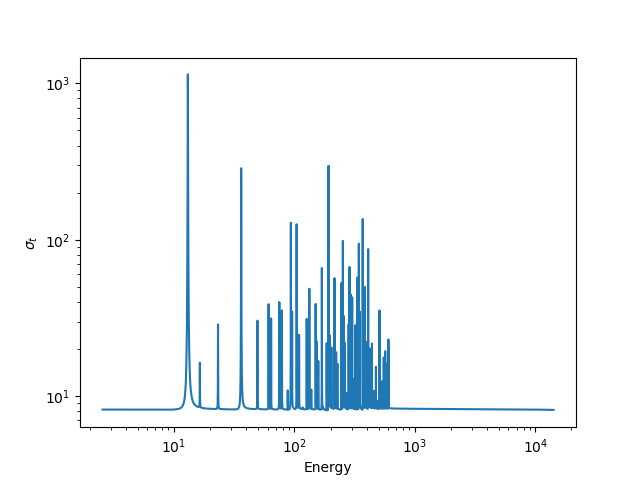

In [43]:
figure()
plot(output.E, output.theo_xs)
xscale('log'); yscale('log')
xlabel('Energy'); ylabel(r'$\sigma_{t}$')
show()

## Adding experimental noise

Now that we have generated a synthetic total cross section (with no experimental corrections in this case), we can use the syndat code package to add noise to the theoretical cross section/transmission.

The first section of code shows how to use the syndat package to add noise directly to the theoretical cross section using functions within syndat. The second section will outline how to do this more rigorously and with high level modules in the syndat package that perform a number of functions.

In [44]:

gausian_noise_xs = syndat.exp_effects.gaus_noise(output.theo_xs, np.sqrt(output.theo_xs)/2)
poisson_noise_xs = syndat.exp_effects.pois_noise(output.theo_xs)


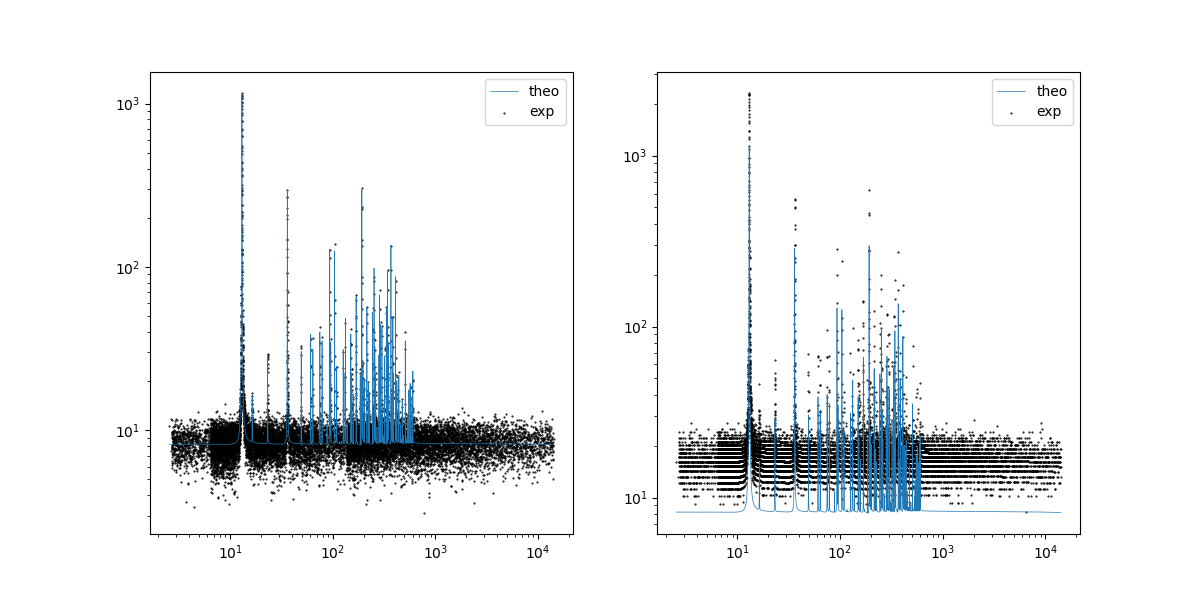

In [45]:

fig, ax = subplots(1,2,figsize=(12,6))
ax[0].plot(output.E, output.theo_xs, label='theo', linewidth=.5)
ax[0].scatter(output.E, gausian_noise_xs, marker='.', color='k', s=1, label='exp')
ax[0].set_xscale('log'); ax[0].set_yscale('log')
ax[0].legend()

ax[1].plot(output.E, output.theo_xs, label='theo', linewidth=.5)
ax[1].scatter(output.E, poisson_noise_xs, marker='.', color='k', s=1, label='exp')
ax[1].set_xscale('log'); ax[1].set_yscale('log')
ax[1].legend()

## A more rigorous methodology for adding noise to experimental data

The evaluation process takes reduced experimental data and fits an experimentally corrected theoretical model to that data. We will call this the evaluation point or evaluation object. For now, it is assumed that the theoretical model can be statistically generated such that the output cross section is a potential realization of the true cross section, just not the realization of the true cross section that is observed in our world (or perhaps there is a very very small probability that the same exact realization is statistically generated as is observed). Because this evaluation object is directly compared to the reduced experimental data, if we assume we have the true theoretical model, we can assume we have the true set of reduced experimental data with zero noise and zero uncertainty. 

write about the generation or un-reduction process - open count rate data is pulled from RPI experiment

write about the noise/uncertainty addition and reduction process

A more in depth discussion of the methodology can be found in the article associated with this work. <a href="https://www.overleaf.com/read/gygkwfqyfpqv" target="_new">Walton, et al.</a>

In [46]:
# opendata = '../synthetic_data/Ta181/rpi-open-ta181.csv'
opendata = '../synthetic_data/Ta181/smooth-open-Ta181.csv'  # the energy/tof grid must match that of the theoretical cross section!!
sammy_xs = '../synthetic_data/Ta181/postdoc_testdata/SAMMY2.LST'

In [47]:

# generation/reduction options
perform_methods = True
add_noise = True
default_exp = True

gen = syndat.generation(perform_methods, default_exp, add_noise, opendata, sammy_xs)

red = syndat.reduction(perform_methods, gen)



In [48]:
# red.trans

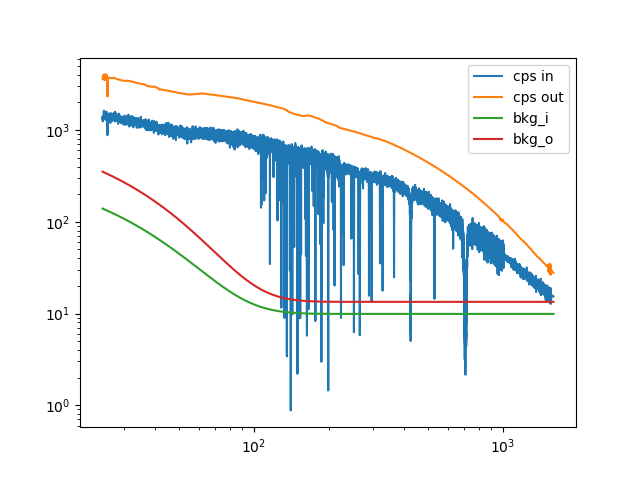

In [49]:
trans = red.trans
cov = red.CovT
tof = red.trans.tof

figure()
plot(tof,red.sdat.cps, label='cps in'); 
plot(tof,red.odat.cps, label='cps out'); 
xscale('log'); yscale('log')
plot(tof, red.redpar.val.ks*red.Bi+red.redpar.val.b0s, label='bkg_i')
plot(tof, red.redpar.val.ko*red.Bi+red.redpar.val.b0o, label='bkg_o')
legend()

### Note

There is some visual structure in the noise/uncertainty of the data that corresponds to the binning stucture used. The spacing between data points is linear in TOF and therefore decreasing with energy, furthermore the flux spectra is just stronger at shorter tof's/higher energies. This causes the conical increase in noise/uncertainty as you move up in tof. The sharp decreases in noise/uncertainty that disrupt this trend are caused by a change in the binning structure. If you increase the width of a tof bin, more counts will contribute to that data point, decreasing the uncertainty/noise.

(100, 150)

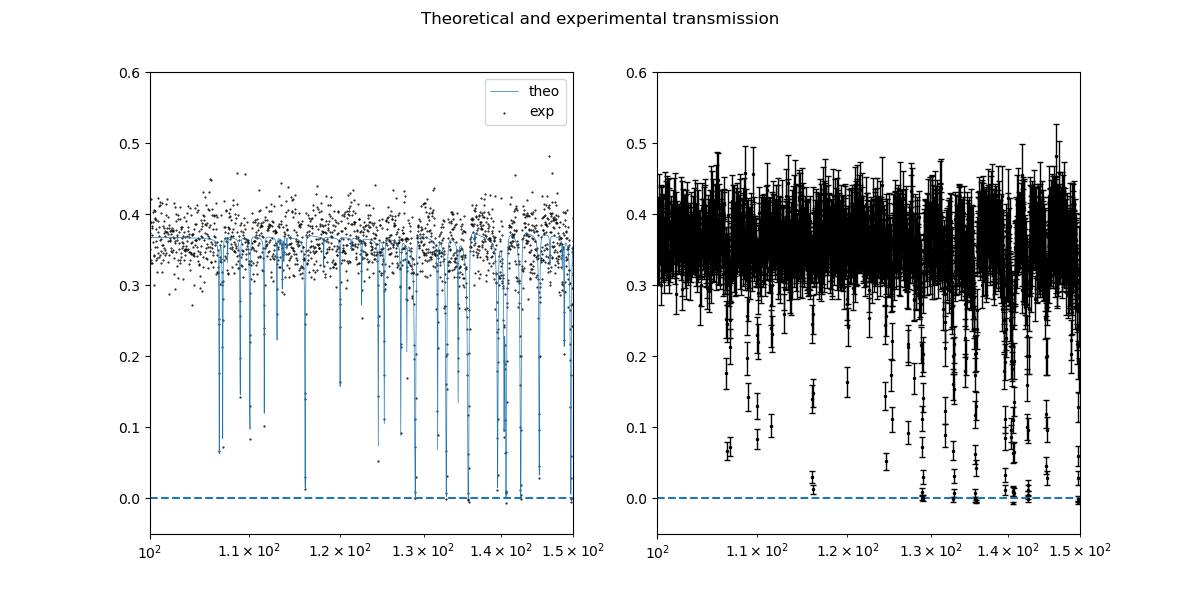

In [50]:
fig,ax = subplots(1,2, figsize=(12,6))
suptitle('Theoretical and experimental transmission')

ax[0].plot(red.trans.tof, red.trans.theo, linewidth=0.5, label='theo')
ax[0].scatter(red.trans.tof, red.trans.expT, marker='.', color='k', s=1, label='exp')
ax[0].set_xscale('log')
ax[0].legend()
ax[0].set_ylim([-0.05,0.6])
ax[0].axhline(y=0.0, ls='--')

ax[1].scatter(red.trans.tof, red.trans.expT, marker='.', color='k', s=1, label='exp')
ax[1].errorbar(red.trans.tof, red.trans.expT, yerr=red.trans.dT, color='k',ecolor='k',elinewidth=1,capsize=2, fmt='.', ms=3)
ax[1].set_ylim(3,250)
ax[1].set_xscale('log')
ax[1].axhline(y=0.0, ls='--')
ax[1].set_ylim([-0.05,0.6])

ax[0].set_xlim([100,150])
ax[1].set_xlim([100,150])

## Conversion from T to xs and uncertainty propagation

This shall be implemented into the syndat package in the future, however it is not yet. The following code could be sped up significantly!

In [51]:
xs_theo = (-1/gen.redpar.val.n)*np.log(red.trans.theo)

xs_exp = (-1/gen.redpar.val.n)*np.log(red.trans.expT)

red.trans['theo_xs'] = xs_theo
red.trans['exp_xs'] = xs_exp

dXi_dn = (1/red.redpar.val.n**2) * np.log(red.trans.theo)
dXi_dT = (-1/red.redpar.val.n) * (1/red.trans.theo)

Jac = np.vstack((np.diag(dXi_dT),dXi_dn))

CovT = spla.block_diag(red.CovT,red.redpar.unc.n**2)

CovXS = Jac.T @ CovT @ Jac

/Users/noahwalton/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/noahwalton/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/noahwalton/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s9/xdv2y9hs0y7g3zzscy35rz4c0000gn/T/ipykernel_85863/3413318468.py:15: RuntimeWarning: invalid value encountered in matmul
  CovXS = Jac.T @ CovT @ Jac


In [52]:
red.trans['exp_xs_unc'] = np.sqrt(np.diag(CovXS))
# red.trans


(250, 500)

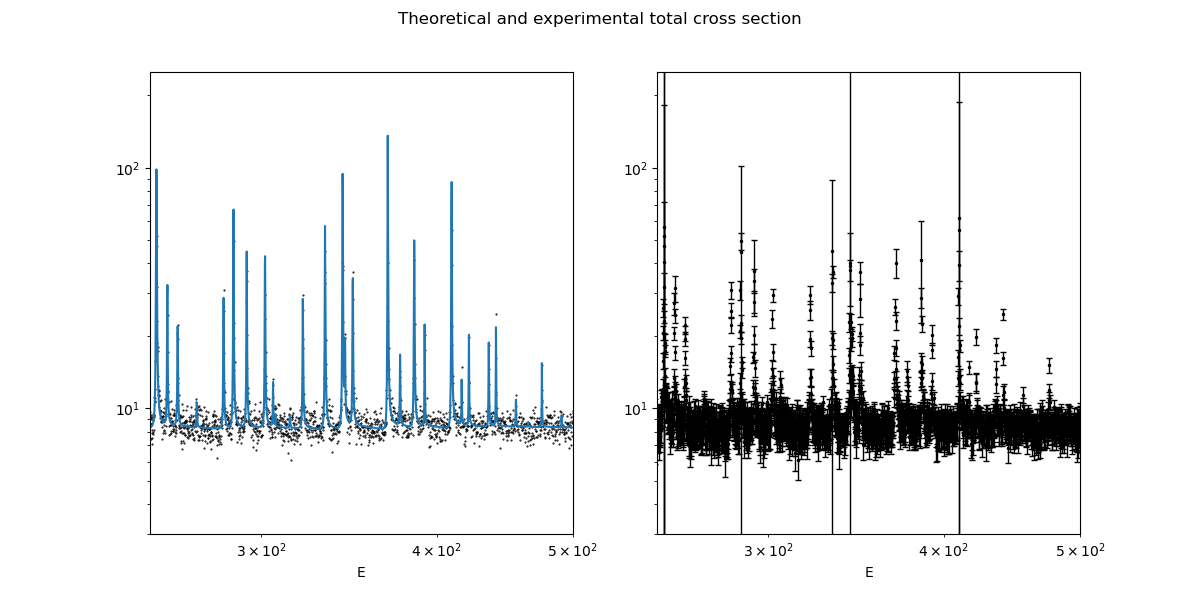

In [53]:


fig,ax = subplots(1,2, figsize=(12,6))
suptitle('Theoretical and experimental total cross section')

ax[0].scatter(red.trans.E, xs_exp, marker='.', color='k', s=1, label='exp')
ax[0].plot(red.trans.E, xs_theo)
ax[0].set_xscale('log'); ax[0].set_yscale('log')
ax[0].set_ylim(3,250)
ax[0].set_xlabel('E')

ax[1].scatter(red.trans.E, xs_exp, marker='.', color='k', s=1, label='exp')
ax[1].errorbar(red.trans.E, xs_exp, yerr=red.trans.exp_xs_unc, color='k',ecolor='k',elinewidth=1,capsize=2, fmt='.', ms=3)
ax[1].set_ylim(3,250)
ax[1].set_xscale('log'); ax[1].set_yscale('log')
ax[1].set_xlabel('E')

ax[0].set_xlim([250,500])
ax[1].set_xlim([250,500])



In [54]:
dxs_xs= red.trans.exp_xs_unc/red.trans.exp_xs

print(np.where(dxs_xs==max(dxs_xs)))
print(np.where(red.trans.exp_xs == min(red.trans.exp_xs)))

print(red.trans.exp_xs_unc[12434])
print(red.trans.exp_xs[12434])
print(red.trans.theo[12434])
print(red.trans.dT[12434])

(array([12434]),)
(array([15257]),)
1299930018.7509105
40.23804626460438
1e-10
0.015599160225010922


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


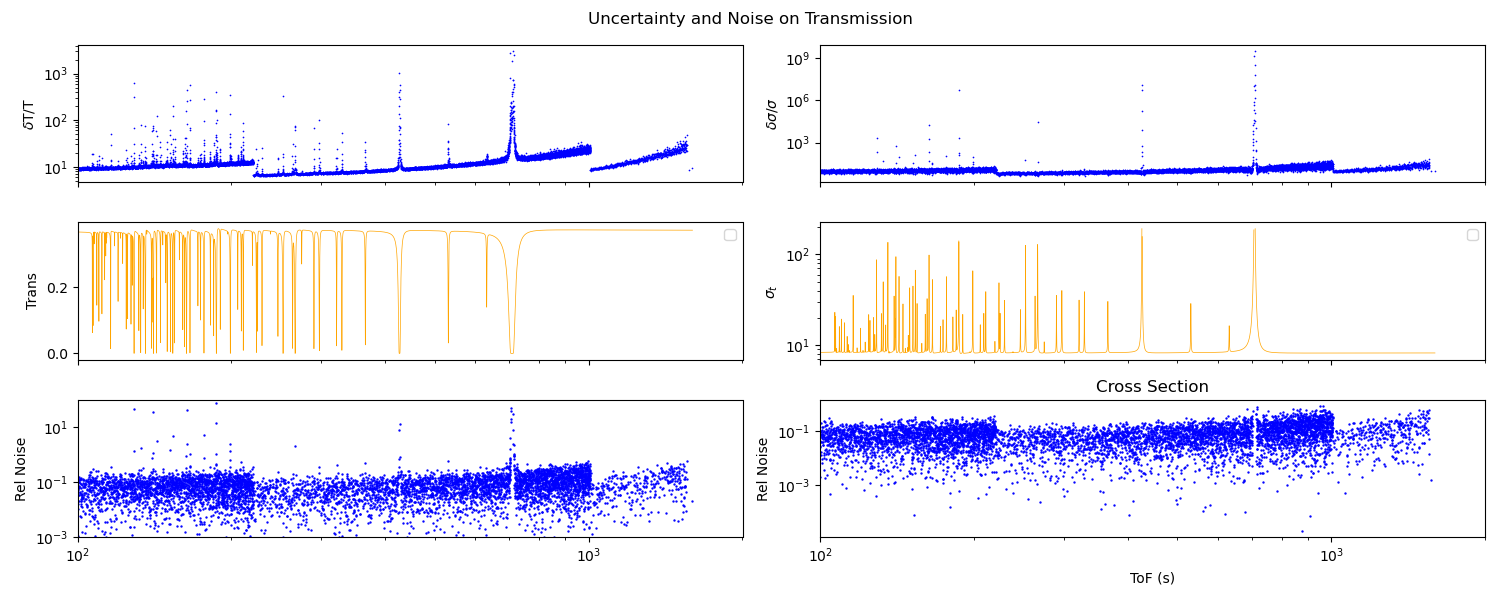

In [55]:
fig, (ax1, ax2, ax3) = subplots(3,2, gridspec_kw={'height_ratios': [1, 1, 1]}, sharex=True, figsize=(15,6)) # , figsize=(12,5)


ax1[0].scatter(red.trans.tof, red.trans.dT/red.trans.expT*100, lw=0.5, color='b', s=0.5, zorder=2)
# ax1[0].set_ylim([0,100]);
ax1[0].set_xlim([1e2,2e3])
ax1[0].set_yscale('log')
ax1[0].set_ylabel('$\delta$T/T'); #('$\sigma$')

ax2[0].plot(red.trans.tof, red.trans.theo, lw= 0.5, c='orange')
#ax2[0].set_yscale('log')
ax2[0].set_xlim([1e2,2e3])
ax2[0].set_ylabel('Trans')
ax2[0].legend()

rel_se = (red.trans.expT-red.trans.theo)/red.trans.theo
ax3[0].scatter(tof, rel_se, s=0.5, c='b')
ax3[0].set_ylim([0.001,100])
ax3[0].set_ylabel('Rel Noise')
ax3[0].set_yscale('log')


# cross section
title('Cross Section')
ax1[1].scatter(red.trans.tof, red.trans.exp_xs_unc/red.trans.exp_xs*100, lw=0.5, color='b', s=0.5, zorder=2)
# ax1[1].set_ylim([3,100]);
ax1[1].set_xlim([1e2,2e3])
ax1[1].set_yscale('log')
ax1[1].set_ylabel('$\delta\sigma/\sigma$'); #('$\sigma$')

ax2[1].plot(red.trans.tof, red.trans.theo_xs, lw= 0.5, c='orange')
ax2[1].set_yscale('log')
ax2[1].set_xlim([1e2,2e3])
ax2[1].set_ylabel(r'$\sigma_{t}$')
ax2[1].legend()

rel_se = (red.trans.exp_xs-red.trans.theo_xs)/red.trans.theo_xs
ax3[1].scatter(tof, rel_se, s=0.5, c='b')
# ax3[1].set_ylim([0.001,1000])
ax3[1].set_ylabel('Rel Noise')
ax3[1].set_yscale('log')


xscale('log')
xlabel('ToF (s)');
suptitle('Uncertainty and Noise on Transmission')
tight_layout()
#plt.show(); plt.close()

## Create SAMMY.DAT files from the generated experimental data

Now that we have a set of noisy, experimental data with associated uncertainty, we can use syndat to put it into a convenient format. One such format is that of the SAMMY.DAT file. This file is read by SAMMY as the experimental data file (energy, value, and uncertainty) and used for the energy grid, bayesian update (GLS), and uncertainty estimation. This is the same file as 'estruct', however, in that case we only cared about the energy grid, the experimental data points/uncertainty were set to 1.0.

In the following example, we will write the transmission and it's uncertainty to a sammy.dat file.

In [56]:

syndat.sammy_interface.write_samdat(red.trans[['E','exp_xs','exp_xs_unc']],'../examples/sammy2.dat')


In [57]:
test = syndat.sammy_interface.readlst('../examples/sammy2.dat')
test




,E,exp_xs,exp_xs_unc,theo_xs,theo_xs_bayes,exp_trans,exp_trans_unc,theo_trans,theo_trans_bayes
0,14177.483896,8.41528400000000000,0.617659,NaN,NaN,NaN,NaN,NaN,NaN
1,14143.567618,7.90610900000000000,0.643798,NaN,NaN,NaN,NaN,NaN,NaN
2,14109.772901,8.94397400000000000,0.599610,NaN,NaN,NaN,NaN,NaN,NaN
3,14076.099164,7.89126000000000000,0.647934,NaN,NaN,NaN,NaN,NaN,NaN
4,14042.545831,8.92039600000000000,0.587847,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
16000,2.687208,10.6327130000000000,1.783906,NaN,NaN,NaN,NaN,NaN,NaN
16001,2.684373,7.15365900000000000,2.827265,NaN,NaN,NaN,NaN,NaN,NaN
16002,2.681543,13.2825730000000000,2.167679,NaN,NaN,NaN,NaN,NaN,NaN
16003,2.635479,8.23120900000000000,0.711200,NaN,NaN,NaN,NaN,NaN,NaN


In [58]:
# figure()
# scatter(test.E, test.exp, marker='.', color='k', s=1, label='exp')
# xscale('log'); yscale('log')